# Projekt końcowy
## Importy

In [1]:
# pip install numpy pandas seaborn matplotlib yfinance pymannkendall statsmodels scipy sklarpy copulas pingouin
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm, lognorm, kstest, shapiro, t, pearsonr, kendalltau, spearmanr
from sklarpy.copulas import student_t_copula, gaussian_copula, clayton_copula, gumbel_copula, frank_copula
from sklarpy.univariate import student_t
from copulas.univariate import (
    GaussianUnivariate,
    GaussianKDE,
    BetaUnivariate,
    GammaUnivariate,
    StudentTUnivariate,
    LogLaplace,
    TruncatedGaussian,
    UniformUnivariate
)
from copulas.univariate.selection import select_univariate
from copulas.multivariate import GaussianMultivariate
from copulas.bivariate import Clayton, Gumbel, Frank
from copulas.bivariate import select_copula
from pingouin import multivariate_normality

## Pobranie danych przez API
Źródło danych Yahoo Finance: https://finance.yahoo.com/chart/AAPL, https://finance.yahoo.com/chart/MSFT.

**AAPL (Apple Inc.) i MSFT (Microsoft Corporation)**\
Obie firmy działają w sektorze technologii, co sugeruje potencjalną korelację ich cen akcji. Zarówno Apple, jak i Microsoft to liderzy rynku w swoich obszarach (hardware i software), więc zmiany w sektorze technologicznym mogą wpływać na obie firmy w podobny sposób.

In [2]:
tickers = ["AAPL", "MSFT"]
data = yf.download(tickers, start="2020-01-01", end="2023-12-31", interval="1d")
data.columns = ["_".join(col).strip() for col in data.columns]
data.head()

[*********************100%***********************]  2 of 2 completed


,Adj Close_AAPL,Adj Close_MSFT,Close_AAPL,Close_MSFT,High_AAPL,High_MSFT,Low_AAPL,Low_MSFT,Open_AAPL,Open_MSFT,Volume_AAPL,Volume_MSFT
Date,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,72.796028,153.630676,75.087502,160.619995,75.150002,160.729996,73.797501,158.330002,74.059998,158.779999,135480400,22622100
2020-01-03 00:00:00+00:00,72.088303,151.717758,74.357498,158.619995,75.144997,159.949997,74.125000,158.059998,74.287498,158.320007,146322800,21116200
2020-01-06 00:00:00+00:00,72.662720,152.109879,74.949997,159.029999,74.989998,159.100006,73.187500,156.509995,73.447502,157.080002,118387200,20813700
2020-01-07 00:00:00+00:00,72.320969,150.723007,74.597504,157.580002,75.224998,159.669998,74.370003,157.320007,74.959999,159.320007,108872000,21634100
2020-01-08 00:00:00+00:00,73.484329,153.123749,75.797501,160.089996,76.110001,160.800003,74.290001,157.949997,74.290001,158.929993,132079200,27746500


## Eksploracyjna analiza danych
Pobraliśmy dzienne dane cen akcji Apple i Microsoft od początku 2020 roku do końca 2023 roku. Możemy sprawdzić wymiary zbioru danych:

In [3]:
print(data.shape)

(1006, 12)


Zbiór ma 12 kolumn i 1006 wierszy. Dane były zapisywane tylko w dni handlowe. Możemy sprawdzić różnice w indeksach:

In [4]:
data.index.to_series().diff().value_counts()

Date
1 days    792
3 days    177
4 days     31
2 days      5
Name: count, dtype: int64

Różnica 1 dnia to wpisy z dni roboczych. Różnica 2 dni występuje gdy święto przypada na inny dzień niż piątek lub poniedziałek. Różnica 3 dni odpowiada przerwom weekendowym, gdy giełda jest zamknięta w soboty i niedziele. Różnica 4 dni to przedłużone weekendy. Wyświetlimy podstawowe informacje o zbiorze danych:

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close_AAPL  1006 non-null   float64
 1   Adj Close_MSFT  1006 non-null   float64
 2   Close_AAPL      1006 non-null   float64
 3   Close_MSFT      1006 non-null   float64
 4   High_AAPL       1006 non-null   float64
 5   High_MSFT       1006 non-null   float64
 6   Low_AAPL        1006 non-null   float64
 7   Low_MSFT        1006 non-null   float64
 8   Open_AAPL       1006 non-null   float64
 9   Open_MSFT       1006 non-null   float64
 10  Volume_AAPL     1006 non-null   int64  
 11  Volume_MSFT     1006 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 102.2 KB
None


Indeks:
- Indeks składa się z dat i godzin. Dane obejmują okres od 2 stycznia 2020 (pierwszy dzień handlowy) do 29 grudnia 2023 (ostatni dzień handlowy). W zbiorze jest 1006 wierszy i jest to łączna liczba dni handlowych od początku 2020 roku do końca 2023 roku.

Dla akcji każdej firmy mamy po sześć kolumn o następujących oznaczeniach:
- **Adj Close**: skorygowana cena zamknięcia, uwzględnia takie zdarzenia jak podział akcji (split) czy dywidendy.
- **Close**: cena zamknięcia w danym dniu, czyli ostatnią cenę, po której akcje były handlowane na koniec dnia giełdowego.
- **High**: najwyższa cena w ciągu dnia handlowego.
- **Low**: najniższa cena w ciągu dnia handlowego.
- **Open**: cena otwarcia, czyli pierwsza cena, po której akcje były handlowane w danym dniu.
- **Volume**: liczba akcji, która zmieniła właściciela tego dnia.

Typy danych w kolumnach:
- float64 (10 kolumn): kolumny z wartościami liczbowymi zmiennoprzecinkowymi (ceny akcji).
- int64 (2 kolumny): kolumny z wartościami całkowitymi (Volume).

Możemy też sprawdzić podstawowe statysktyki zbioru:

In [6]:
print(data.describe())

       Adj Close_AAPL  Adj Close_MSFT   Close_AAPL   Close_MSFT    High_AAPL  \
count     1006.000000     1006.000000  1006.000000  1006.000000  1006.000000   
mean       138.711616      256.641233   140.808131   262.781928   142.321389   
std         33.540053       55.341065    33.313857    54.621965    33.430571   
min         54.509758      129.881042    56.092499   135.419998    57.125000   
25%        121.054728      214.892303   123.592501   221.469994   125.030003   
50%        143.596535      253.355339   145.860001   259.464996   147.264999   
75%        164.086521      296.604347   166.214996   304.322487   168.147503   
max        197.144180      379.859497   198.110001   382.700012   199.619995   

         High_MSFT     Low_AAPL     Low_MSFT    Open_AAPL    Open_MSFT  \
count  1006.000000  1006.000000  1006.000000  1006.000000  1006.000000   
mean    265.509354   139.143536   259.803986   140.675507   262.669344   
std      54.732373    33.179199    54.415635    33.310018

Wnioski:
- Wszystkie kolumny zawierają dane dla 1006 dni handlowych, co oznacza, że brak danych nie występuje.
- Średnia cena zamknięcia skorygowana dla AAPL wynosi 138.71 USD, a dla MSFT 256.64 USD. Medianowe wartości (percentyl 50%) są nieco wyższe, odpowiednio 143.60 USD i 253.36 USD, co sugeruje lekkie przesunięcie cen ku wyższym wartościom.
- Rozpiętość cen zamknięcia dla AAPL wynosi od 54.51 USD do 197.14 USD, a dla MSFT od 129.88 USD do 379.86 USD, co wskazuje na znaczne wahania cen w analizowanym okresie.
- Wartości kwartylowe pokazują, że przez większość czasu ceny zamknięcia AAPL znajdowały się w przedziale 121.05-164.09 USD, a dla MSFT w przedziale 214.89-296.60 USD.
- Średnia cena otwarcia dla AAPL to 140.68 USD, a dla MSFT 262.67 USD, co jest zbliżone do średnich cen zamknięcia, wskazując na stabilność cen w trakcie dnia.
- Średnia dzienna zmienność (rozpiętość między najwyższą a najniższą ceną) wynosi około 33.43 USD dla AAPL i 54.73 USD dla MSFT.
- Średni wolumen obrotu dla AAPL to 98.95 milionów akcji, a dla MSFT 30.65 milionów akcji dziennie. Duże odchylenia standardowe (54.40 mln dla AAPL i 12.99 mln dla MSFT) wskazują na zróżnicowaną aktywność inwestorów w poszczególnych dniach.
- Najwyższe wartości wolumenu obrotu dla AAPL wynoszą 426.51 mln akcji, co jest czterokrotnością medianowego wolumenu (84.68 mln akcji) i sugeruje występowanie dni o wyjątkowo dużym zainteresowaniu rynkowym.

Interesują nas kolumny opisujące ceny zamknięcia. Możemy przedstawić szeregi czasowe cen zamknięcia na wykresie:

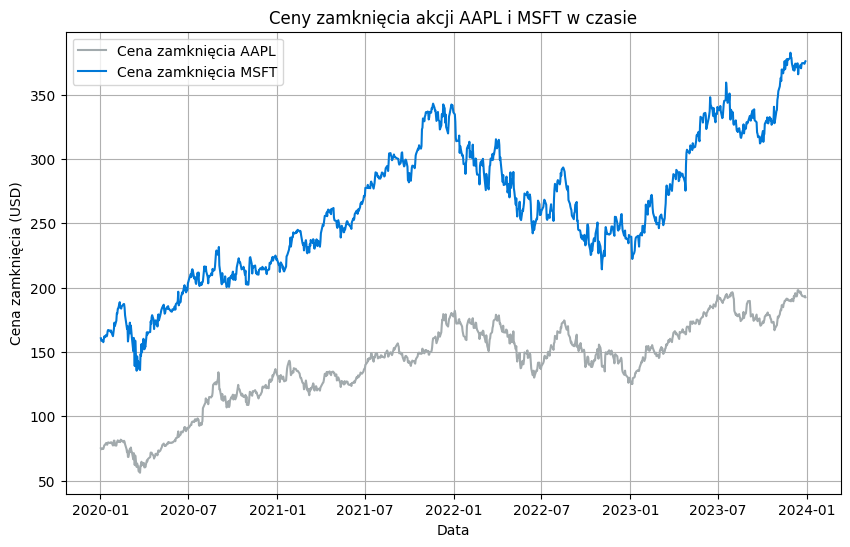

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["Close_AAPL"], color='#A2AAAD', label="Cena zamknięcia AAPL")
plt.plot(data.index, data["Close_MSFT"], color='#0078D7', label="Cena zamknięcia MSFT")
plt.xlabel("Data")
plt.ylabel("Cena zamknięcia (USD)")
plt.title("Ceny zamknięcia akcji AAPL i MSFT w czasie")
plt.legend()
plt.grid()
plt.show()

Z wykresu można zauważyć, że obie zmienne (ceny zamknięcia akcji AAPL i MSFT) wykazują pewne podobieństwa w trendach (wykazują ogólny trend wzrostowy), co sugeruje, że mogą być skorelowane. Obecnośc tendu możemy zweryfikować za pomocą testu Manna-Kendalla:

In [8]:
trend_test1 = mk.original_test(data['Close_AAPL'])
print(f"Trend: {trend_test1.trend}")
print(f"Nachylenie: {trend_test1.slope}")
print(f"p-value: {trend_test1.p}")

Trend: increasing
Nachylenie: 0.10042755960568679
p-value: 0.0


In [9]:
trend_test2 = mk.original_test(data['Close_MSFT'])
print(f"Trend: {trend_test2.trend}")
print(f"Nachylenie: {trend_test2.slope}")
print(f"p-value: {trend_test2.p}")

Trend: increasing
Nachylenie: 0.16237219414267284
p-value: 0.0


Test potwierdza obecność trednu rosnącego dla obu szeregów. Zróżnicowanie danych może pomóc w usunięciu trendu i sprawieniu, by szeregi czasowe stały się stacjonarne (czyli ich statystyki (średnia, wariancja, kowariancja) nie zmieniały się w czasie).

## Zróżnicowanie szeregów czasowych
Nasze dane są nieciągłe (brakuje weekendów i świąt), więc różnicowanie będzie dotyczyło tylko dni handlowych. Uzupełnianie brakujących dni sztucznymi wartościami (np. przez forward fill) może wprowadzić fałszywe informacje do analizy. W rezultacie uwzględniamy tylko rzeczywiste zmiany cen w dostępnych datach.

In [10]:
data["diff_aapl"] = data["Close_AAPL"].diff()
data["diff_msft"] = data["Close_MSFT"].diff()
data = data.dropna()

Możemy wyświetlić podstawowe statystyki otrzymanych szeregów start:

In [11]:
print(data[["diff_aapl","diff_msft"]].describe())

         diff_aapl    diff_msft
count  1005.000000  1005.000000
mean      0.116858     0.214348
std       2.646546     4.845823
min     -10.519997   -23.410004
25%      -1.300003    -2.449997
50%       0.149994     0.229996
75%       1.660004     3.059998
max      12.000000    19.949982


Wnioski:
- Średnia dzienna zmiana ceny dla AAPL wynosi 0.12 USD, a dla MSFT 0.21 USD, co sugeruje, że MSFT wykazuje większe dzienne wzrosty w analizowanym okresie.
- Odchylenie standardowe wynosi 2.65 USD dla AAPL i 4.85 USD dla MSFT, wskazując na znacznie większą zmienność cen akcji MSFT w porównaniu do AAPL.
- Minimalne dzienne zmiany to -10.52 USD dla AAPL i -23.41 USD dla MSFT, co świadczy o istnieniu dni z dużymi spadkami cen.
- Maksymalne dzienne wzrosty wynoszą 12.00 USD dla AAPL i 19.95 USD dla MSFT, co pokazuje potencjalne znaczące skoki cen w niektórych dniach.
- W 25% przypadków zmiany dzienne AAPL wynosiły mniej niż -1.30 USD, a dla MSFT mniej niż -2.45 USD.
- Mediana zmian dziennych to 0.15 USD dla AAPL i 0.23 USD dla MSFT, co oznacza, że zmiany były najczęściej bliskie zeru lub nieznacznie dodatnie.
- W 75% przypadków zmiany dzienne AAPL wynosiły mniej niż 1.66 USD, a dla MSFT mniej niż 3.06 USD.

Ogólnie, akcje MSFT wykazują większą zmienność zarówno w górę, jak i w dół w porównaniu do AAPL. Sprawdzimy na wykresie jak zmieniły się dane:

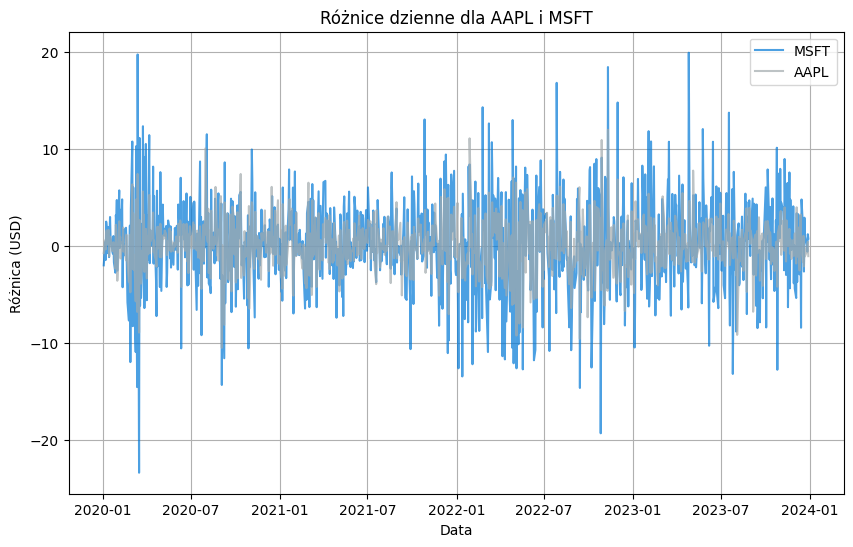

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["diff_msft"], label="MSFT", color="#0078D7", alpha=0.7)
plt.plot(data.index, data["diff_aapl"], label="AAPL", color="#A2AAAD", alpha=0.7)
plt.title("Różnice dzienne dla AAPL i MSFT")
plt.xlabel("Data")
plt.ylabel("Różnica (USD)")
plt.legend()
plt.grid(True)
plt.show()

Na wykresie nie zauważamy wyraźnego trendu. Sprawdzimy to za pomocą testu Manna-Kendalla:

In [13]:
trend_test1 = mk.original_test(data['diff_aapl'])
print(f"Trend: {trend_test1.trend}")
print(f"Nachylenie: {trend_test1.slope}")
print(f"p-value: {trend_test1.p}")

Trend: no trend
Nachylenie: -8.717606013083212e-05
p-value: 0.7386454235742237


In [14]:
trend_test2 = mk.original_test(data['diff_msft'])
print(f"Trend: {trend_test2.trend}")
print(f"Nachylenie: {trend_test2.slope}")
print(f"p-value: {trend_test2.p}")

Trend: no trend
Nachylenie: -8.545853425003815e-05
p-value: 0.8644741815240118


Test potwierdza pozbycie się trendu dla obu szeregów. Możemy również przetestować stacjonarność zróżnicowanych szeregów za pomocą rozszerzonego testu Dickey-Fullera (ADF):

In [15]:
result1 = adfuller(data["diff_aapl"].dropna())
print(f"p-value: {result1[1]}")

if result1[1] < 0.05:
    print("Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej. Szereg czasowy jest niestacjonarny.")

p-value: 0.0
Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.


In [16]:
result2 = adfuller(data["diff_aapl"].dropna())
print(f"p-value: {result2[1]}")

if result2[1] < 0.05:
    print("Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.")
else:
    print("Brak podstaw do odrzucenia hipotezy zerowej. Szereg czasowy jest niestacjonarny.")

p-value: 0.0
Odrzucamy hipotezę zerową. Szereg czasowy jest stacjonarny.


Możemy odrzucić hipotezę zerową, oba szeregi strat są stacjonarne. Sprawdzimy wartości odstające:

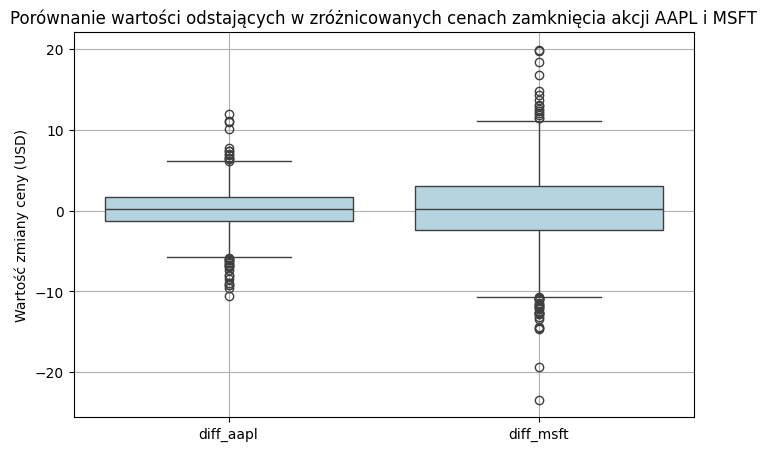

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data[["diff_aapl","diff_msft"]], color='lightblue')
plt.title("Porównanie wartości odstających w zróżnicowanych cenach zamknięcia akcji AAPL i MSFT")
plt.xlabel("")
plt.ylabel("Wartość zmiany ceny (USD)")
plt.grid(True)
plt.show()

- Mediana zmian cen akcji Apple (diff_aapl) jest bliska zeru, co sugeruje, że większość zmian cen jest niewielka. Mediana zmian cen akcji Microsoft (diff_msft) jest również bliska zeru.
- Rozstęp międzykwartylowy dla Apple jest mniejszy niż dla Microsoft, co oznacza, że zmiany cen akcji Apple są mniej zróżnicowane niż zmiany cen akcji Microsoft.
- W obu przypadkach widoczne są wartości odstające, które są bardziej liczne w przypadku Microsoft. Wartości te reprezentują dni, w których zmiany cen były znacznie większe niż w pozostałych dniach.

Policzymy korelację liniową, statystyki Tau Kendalla oraz Rho Spearmana w celu oceny zależności pomiędzy zmiennymi.
Korelacja Pearsona mierzy liniową zależność między zmiennymi. Wynik to współczynnik korelacji Pearsona (wartość od -1 do 1) i wartość p, która ocenia istotność tej korelacji.

In [18]:
pearson_corr, pearson_p = pearsonr(data["diff_aapl"], data["diff_msft"])
print(f"Korelacja Pearsona: {pearson_corr}, p-value: {pearson_p}")

Korelacja Pearsona: 0.7216509599122131, p-value: 2.1413031735465261e-162


Wartość 0.721 wskazuje na silną, dodatnią zależność liniową między cenami zamknięcia akcji AAPL i MSFT. Wartość p jest bardzo mała ($2.14 \times 10^{-162}$), co oznacza, że zależność jest statystycznie istotna.

Statystyka Tau Kendalla mierzy monotoniczną zależność między zmiennymi na podstawie par porównywalnych.

In [19]:
kendall_corr, kendall_p = kendalltau(data["diff_aapl"], data["diff_msft"])
print(f"Statystyka Tau Kendalla: {kendall_corr}, p-value: {kendall_p}")

Statystyka Tau Kendalla: 0.5582598978439234, p-value: 1.29192123393822e-154


Wartość 0.558 wskazuje na umiarkowaną dodatnią monotoniczną zależność między zmiennymi. Tau Kendalla jest bardziej odporny na wartości odstające niż korelacja Pearsona. Bardzo niski poziom p ($1.29 \times 10^{-154}$) wskazuje, że zależność jest istotna.

Statystyka Rho Spearmana mierzy monotoniczną zależność na podstawie rang zmiennych.

In [20]:
spearman_corr, spearman_p = spearmanr(data["diff_aapl"], data["diff_msft"])
print(f"Statystyka Rho Spearmana: {spearman_corr}, p-value: {spearman_p}")

Statystyka Rho Spearmana: 0.7376369392970201, p-value: 2.8322690443130102e-173


Wartość 0.738 wskazuje na silną dodatnią monotoniczną zależność między zmiennymi. Rho Spearmana, podobnie jak Tau Kendalla, opiera się na rangach i jest mniej wrażliwy na wartości odstające. Bardzo mała wartość p ($2.83 \times 10^{-173}$) wskazuje na istotność statystyczną tej zależności.

Wnioski:
- Wszystkie trzy miary korelacji wskazują, że istnieje statystycznie istotna zależność między zmianami wartości diff_aapl i diff_msft.
- Korelacja Pearsona sugeruje, że zależność liniowa jest silna (0.721). Tau Kendalla i Spearmana wskazują na umiarkowaną i silną zależność monotoniczną.

## Dopasowanie rozkładów

Za pomocą histogramów możemy zobaczyć, jak rozkładają się wartości w zróżnicowanych szeregach cen akcji AAPL i MSFT:

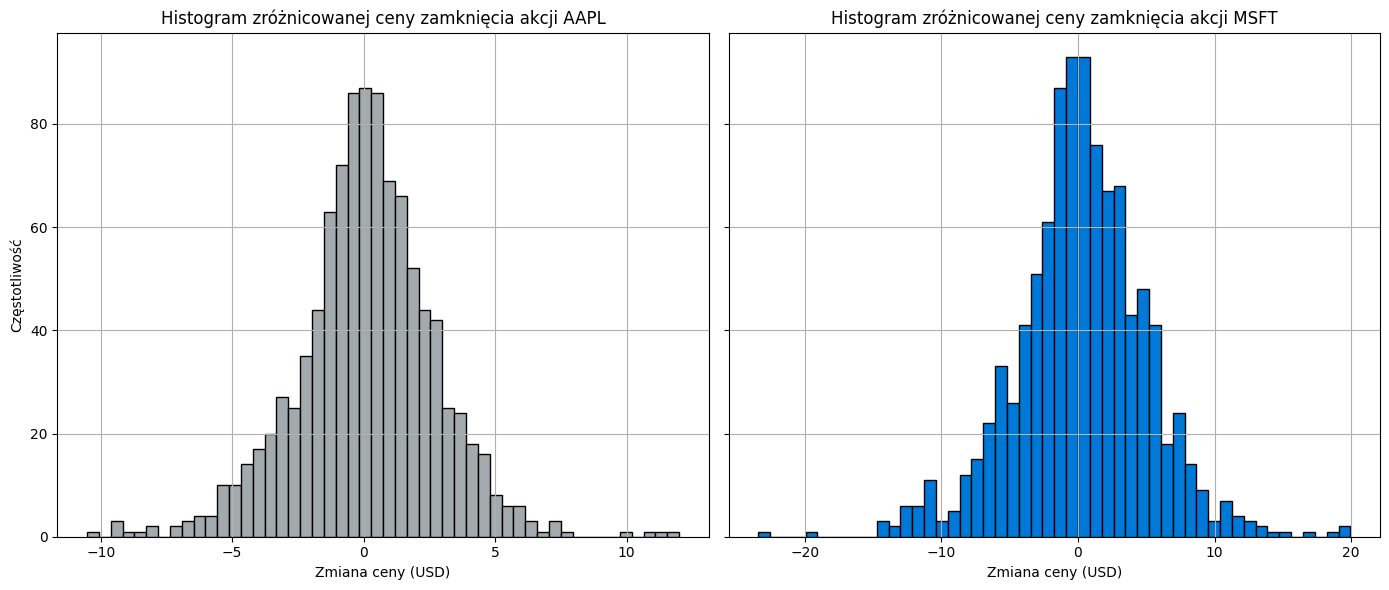

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].hist(data["diff_aapl"], bins=50, edgecolor='k', color='#A2AAAD')
axes[0].set_title("Histogram zróżnicowanej ceny zamknięcia akcji AAPL")
axes[0].set_xlabel("Zmiana ceny (USD)")
axes[0].set_ylabel("Częstotliwość")
axes[0].grid(True)

axes[1].hist(data["diff_msft"], bins=50, edgecolor='k', color='#0078D7')
axes[1].set_title("Histogram zróżnicowanej ceny zamknięcia akcji MSFT")
axes[1].set_xlabel("Zmiana ceny (USD)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

- Oba histogramy mają kształt zbliżony do dzwonu, co sugeruje, że zmiany cen mogą pochodzić z rozkładów normalnych.
- Histogram dla AAPL jest bardziej symetryczny i skoncentrowany wokół zera, co oznacza, że zmiany ceny zamknięcia akcji AAPL są bardziej stabilne i mniej zmienne.
- Histogram dla MSFT jest również zbliżony do rozkładu normalnego, ale ma nieco większą zmienność w porównaniu do AAPL, co może sugerować większą niestabilność cen akcji MSFT.

Przetestujemy, czy dane pochodzą z rozkładu normalnego za pomocą testu Shapiro-Wilka:

In [22]:
stat, p_value = shapiro(data["diff_aapl"])
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu normalnego.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.")

Statystyka testowa: 0.9822238288274578
p-value: 1.0002383593726718e-09
Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.


In [23]:
stat, p_value = shapiro(data["diff_msft"])
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu normalnego.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.")

Statystyka testowa: 0.9834952272420803
p-value: 3.050641445389194e-09
Odrzucamy hipotezę. Dane nie są zgodne z rozkładem normalnym.


Oba szeregi nie pochodzą z rozkładu normalnego. Czy pochodzą z rozkładu t-Studenta? Zastosujemy test Kołmogorowa-Smirnowa do oceny zgodności danych z rozkładem t-Studenta:

In [24]:
params = t.fit(data["diff_aapl"])

stat, p_value = kstest(data["diff_aapl"], 't', args=params)
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem t-Studenta.")

Statystyka testowa: 0.016842011857456818
p-value: 0.9333777782839556
Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.


In [25]:
params = t.fit(data["diff_msft"])

stat, p_value = kstest(data["diff_msft"], 't', args=params)
print(f"Statystyka testowa: {stat}")
print(f"p-value: {p_value}")

if p_value > 0.05:
    print("Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.")
else:
    print("Odrzucamy hipotezę. Dane nie są zgodne z rozkładem t-Studenta.")

Statystyka testowa: 0.020821417773338513
p-value: 0.7680382189265599
Brak podstaw do odrzucenia hipotezy. Dane mogą pochodzić z rozkładu t-Studenta.


Zatem oba szeregi start mogą pochodzić z rozkładu t-Studenta.

## Dopasowanie kopuł - sklarpy (błąd z kopułą Claytona)
Dopasujemy pięć kopuł i ocenimy ich dopasowanie:
- eliptyczne - t-Studenta, normalna,
- archimedejskie - Gumbela, Claytona, Franka.

Sprawdzimy jak wygląda nasz rozkład łączny:

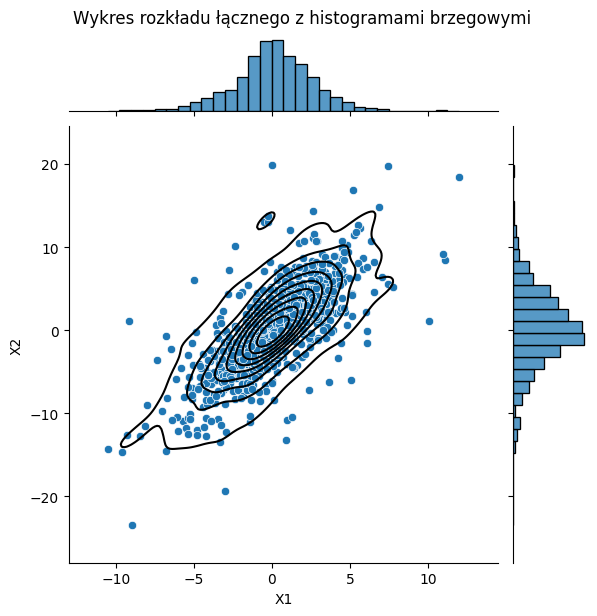

In [26]:
g = sns.jointplot(x="diff_aapl", y="diff_msft", data=data, kind="scatter", marginal_kws=dict(bins=30, fill=True))

g.fig.suptitle("Wykres rozkładu łącznego z histogramami brzegowymi", y=1.02)
sns.kdeplot(data=data, x="diff_aapl", y="diff_msft", color="black")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

Kontury mają kształt eliptyczny i są skoncentrowane wokół środka, co sugeruje, że rozkład jest symetryczny i dzwonowaty.

Ponieważ rozkłady brzegowe mogą pochodzić z rozkładu t-Studenta, przekształcimy szeregi na dystrybuanty brzegowe dopasowując rozkłady t-Studenta:

In [27]:
fitted_marginals = {
    0: student_t.fit(data["diff_aapl"]),
    1: student_t.fit(data["diff_msft"])
}

data["u1"] = fitted_marginals[0].cdf(np.array(data["diff_aapl"]))
data["u2"] = fitted_marginals[1].cdf(np.array(data["diff_msft"]))

### Kopuła T-Studenta

In [28]:
student_t_fit = student_t_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.DataFrame({
    "Copula": ["Student-t"],
    "Log-Likelihood": [student_t_fit.loglikelihood()],
    "AIC": [student_t_fit.aic()],
    "BIC": [student_t_fit.bic()]
})

print(results.loc[0])

Copula              Student-t
Log-Likelihood   -3652.716181
AIC               7321.432361
BIC               7360.734304
Name: 0, dtype: object


### Kopuła Gaussa

In [29]:
gaussian_fit = gaussian_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Gaussian"],
        "Log-Likelihood": [gaussian_fit.loglikelihood()],
        "AIC": [gaussian_fit.aic()],
        "BIC": [gaussian_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[1])

Copula               Gaussian
Log-Likelihood   -3657.334139
AIC               7328.668278
BIC               7363.057478
Name: 1, dtype: object


### Kopuła Claytona - zła, niedobra

In [30]:
clayton_fit = clayton_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals, verbose=True)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Clayton"],
        "Log-Likelihood": [clayton_fit.loglikelihood()],
        "AIC": [clayton_fit.aic()],
        "BIC": [clayton_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[2])

Copula                Clayton
Log-Likelihood    1324.852209
AIC              -2633.704418
BIC              -2594.402476
Name: 2, dtype: object


C:\Users\magda\repos\Market_risk\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
C:\Users\magda\repos\Market_risk\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\magda\repos\Market_risk\venv\lib\site-packages\sklarpy\multivariate\_prefit_dists.py:620: RuntimeWarning: overflow encountered in exp
  return np.exp(loglikelihood)
C:\Users\magda\repos\Market_risk\venv\lib\site-packages\sklarpy\copulas\_prefit_dists.py:1053: R

### Kopuła Gumbela

In [31]:
gumbel_fit = gumbel_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Gumbel"],
        "Log-Likelihood": [gumbel_fit.loglikelihood()],
        "AIC": [gumbel_fit.aic()],
        "BIC": [gumbel_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[3])

Copula                 Gumbel
Log-Likelihood   -2621.583016
AIC               5259.166032
BIC               5298.467975
Name: 3, dtype: object


C:\Users\magda\repos\Market_risk\venv\lib\site-packages\sklarpy\multivariate\_prefit_dists.py:620: RuntimeWarning: overflow encountered in exp
  return np.exp(loglikelihood)


### Kopuła Franka

In [32]:
frank_fit = frank_copula.fit(data[["u1", "u2"]], mdists=fitted_marginals)

results = pd.concat(
    [results, pd.DataFrame({
        "Copula": ["Frank"],
        "Log-Likelihood": [frank_fit.loglikelihood()],
        "AIC": [frank_fit.aic()],
        "BIC": [frank_fit.bic()],
    })],
    ignore_index=True
)

print(results.loc[4])

C:\Users\magda\repos\Market_risk\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


Copula                  Frank
Log-Likelihood   -2598.689244
AIC               5213.378489
BIC               5252.680431
Name: 4, dtype: object


C:\Users\magda\repos\Market_risk\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
C:\Users\magda\repos\Market_risk\venv\lib\site-packages\sklarpy\multivariate\_prefit_dists.py:620: RuntimeWarning: overflow encountered in exp
  return np.exp(loglikelihood)


Możemy ocenić dopasowanie kopuł za pomocą miar:
- Log-Likelihood: jest to miara, która ocenia, jak dobrze model kopuły pasuje do danych. Wyższa wartość log-likelihood wskazuje na lepsze dopasowanie modelu do danych.
- AIC (Akaike Information Criterion): AIC uwzględnia zarówno dopasowanie modelu, jak i jego złożoność. Niższa wartość AIC wskazuje na lepszy model, ponieważ oznacza lepsze dopasowanie przy mniejszej złożoności.
- BIC (Bayesian Information Criterion): BIC również uwzględnia dopasowanie modelu i jego złożoność, ale karze bardziej za złożoność niż AIC. Niższa wartość BIC wskazuje na lepszy model.
- 
Zatem niższe wartości AIC i BIC oraz wyższa wartość log-likelihood wskazują na lepsze dopasowanie kopuły do danych.

In [33]:
print("\nZestawienie wyników dla wszystkich kopuł:")
print(results)


Zestawienie wyników dla wszystkich kopuł:
      Copula  Log-Likelihood          AIC          BIC
0  Student-t    -3652.716181  7321.432361  7360.734304
1   Gaussian    -3657.334139  7328.668278  7363.057478
2    Clayton     1324.852209 -2633.704418 -2594.402476
3     Gumbel    -2621.583016  5259.166032  5298.467975
4      Frank    -2598.689244  5213.378489  5252.680431


Wyniki dla kopuły Claytona znacznie różnią się od pozostałych (w porównaniu do pozostałych wyglądają jak błąd lub nadmierne dopasowanie do danych). Przyjmiemy, że wynika to z błędu w impementacji tej kopuły. Aby wybrać najlepszą kopułę będziemy patrzeć na wyniki testu BIC. Posortujemy tabelę rosnąco względem kolumny BIC, więc najlepsza kopuła będzie na samej górze:

In [34]:
results_sorted = results.sort_values(by="BIC", ascending=True).reset_index(drop=True)

print("\nTabela z wynikami (posortowana według BIC):")
print(results_sorted)


Tabela z wynikami (posortowana według BIC):
      Copula  Log-Likelihood          AIC          BIC
0    Clayton     1324.852209 -2633.704418 -2594.402476
1      Frank    -2598.689244  5213.378489  5252.680431
2     Gumbel    -2621.583016  5259.166032  5298.467975
3  Student-t    -3652.716181  7321.432361  7360.734304
4   Gaussian    -3657.334139  7328.668278  7363.057478


Odrzucamy kopułę Claytona. Najlepsza kopuła wedlug BIC to kopuła Franka. Sprawdzimy dopasowanie kopuł za pomocą wykresów, generując z kopuł przykładowe próbki i porównując je z rozkładem łącznym oryginalnych danych. Możemy wygenerować próbki za pomocą metody rvs():

In [35]:
student_t_samples = student_t_fit.rvs(len(data))
gaussian_samples = gaussian_fit.rvs(len(data))
clayton_samples = clayton_fit.rvs(len(data))
gumbel_samples = gumbel_fit.rvs(len(data))
frank_samples = frank_fit.rvs(len(data))

Rysujemy wykresy rozkładu dwuwymiarowego uzywając sns.kdeplot(x,y). Punkty na wykresie oznaczają dane oryginalne, natomiast linie zostały wygenerowane na podstawie próbek z dopasowanych kopuł:

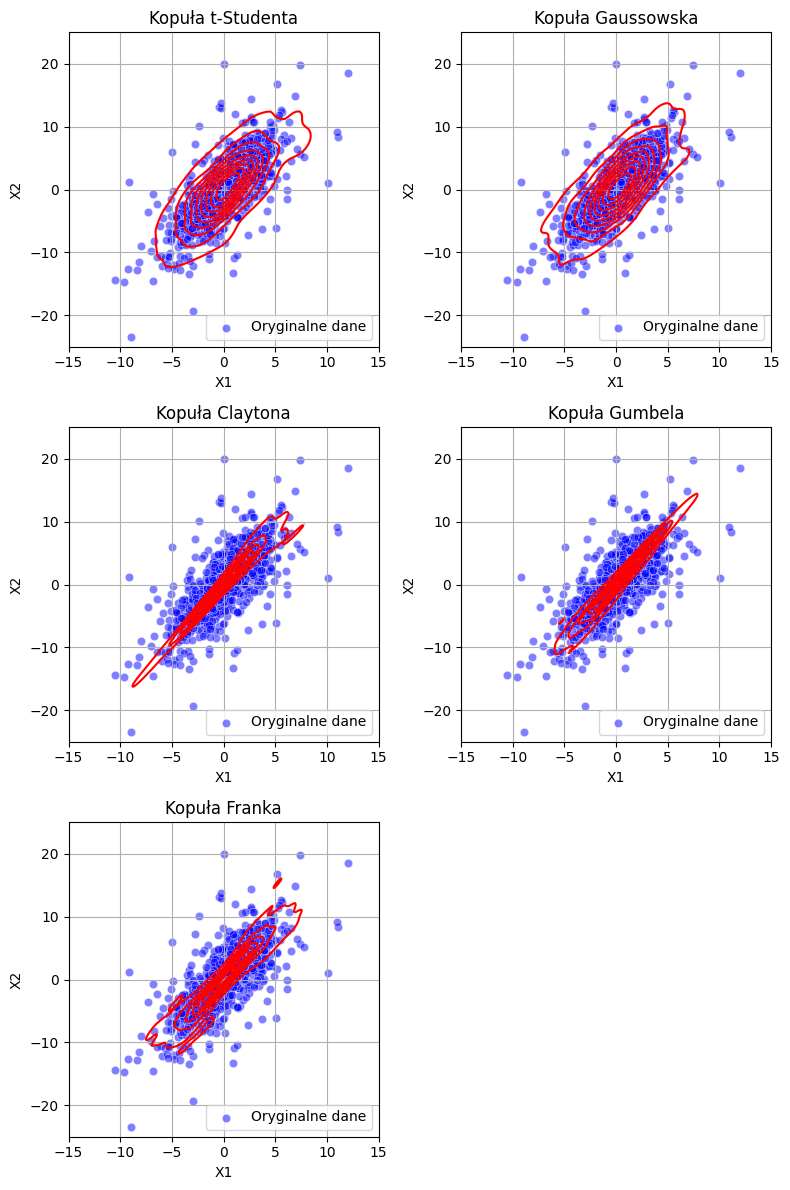

In [36]:
fig, ax = plt.subplots(3, 2, figsize=(8, 12))
axes = ax.flatten()

copula_samples = [
    (student_t_samples, "Kopuła t-Studenta"),
    (gaussian_samples, "Kopuła Gaussowska"),
    (clayton_samples, "Kopuła Claytona"),
    (gumbel_samples, "Kopuła Gumbela"),
    (frank_samples, "Kopuła Franka")
]

for i, (samples, title) in enumerate(copula_samples):
    sns.scatterplot(
        x=data["diff_aapl"], y=data["diff_msft"],
        ax=axes[i], color="blue", alpha=0.5, label="Oryginalne dane"
    )
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], ax=axes[i], color="red")
    axes[i].set_title(title)
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")
    axes[i].legend()
    axes[i].set_xlim(-15, 15)
    axes[i].set_ylim(-25, 25)
    axes[i].grid(True)

axes[-1].axis("off")

plt.tight_layout()
plt.show()

Wnioski...

## Copulas - nie ma kopuły t-Studenta dla rozkładów dwuwymiarowych
Możemy wykorzystać wbudowaną metodę select_univariate() aby dopasować najlepsze rozkłady brzegowe:

In [37]:
candidates = [
    GaussianUnivariate,
    GaussianKDE,
    BetaUnivariate,
    GammaUnivariate,
    StudentTUnivariate
]

best_model1 = select_univariate(data["diff_aapl"], candidates)
best_model2 = select_univariate(data["diff_msft"], candidates)
print(f"Najlepszy rozkład brzegowy AAPL: {type(best_model1).__name__}")
print(f"Najlepszy rozkład brzegowy MSFT: {type(best_model2).__name__}")

C:\Users\magda\repos\Market_risk\venv\lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\magda\repos\Market_risk\venv\lib\site-packages\scipy\stats\_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


Najlepszy rozkład brzegowy AAPL: StudentTUnivariate
Najlepszy rozkład brzegowy MSFT: StudentTUnivariate


Ponieważ rozkłady brzegowe mogą pochodzić z rozkładu t-Studenta, przekształcimy szeregi na dystrybuanty brzegowe dopasowując rozkłady t-Studenta:

In [38]:
marginal_aapl = StudentTUnivariate()
marginal_aapl.fit(data["diff_aapl"])
marginal_msft = StudentTUnivariate()
marginal_msft.fit(data["diff_msft"])

data["u1"] = marginal_aapl.cdf(data["diff_aapl"])
data["u2"] = marginal_msft.cdf(data["diff_msft"])
print(data[["u1", "u2"]].head())

                                 u1        u2
Date                                         
2020-01-03 00:00:00+00:00  0.347134  0.292154
2020-01-06 00:00:00+00:00  0.578363  0.513261
2020-01-07 00:00:00+00:00  0.410635  0.338230
2020-01-08 00:00:00+00:00  0.679384  0.704815
2020-01-09 00:00:00+00:00  0.739537  0.661978


W pętli dopasujemy kopuły Gaussa, Claytona, Franka i Gumbela (w pakiecie copulas nie ma kopuły t-Studenta dla rozkładów dwuwymiarowych, nie ma też wbudowanych funkcji liczących log-likelihood, AIC i BIC):

In [39]:
data_u = data[["u1", "u2"]].to_numpy()

copula_classes = [GaussianMultivariate, Clayton, Gumbel, Frank]
results = []

for copula_class in copula_classes:
    copula = copula_class()
    copula.fit(data_u)

    # Log-likelihood
    pdf_values = copula.probability_density(data_u)
    log_likelihood = np.sum(np.log(pdf_values))

    if isinstance(copula, GaussianMultivariate):
        # GaussianMultivariate: liczba parametrów korelacji + liczba parametrów brzegowych
        d = data_u.shape[1]  # Wymiar danych (liczba zmiennych)
        num_correlation_params = d * (d - 1) / 2  # Liczba niezależnych elementów w macierzy korelacji
        num_univariate_params = len(copula.univariates)  # Liczba dystrybucji brzegowych
        num_params = num_correlation_params + num_univariate_params
    else:
        # Clayton, Frank, Gumbel: 1 parametr theta
        num_params = 1

    n = len(data_u)

    # AIC i BIC
    aic = -2 * log_likelihood + 2 * num_params
    bic = -2 * log_likelihood + num_params * np.log(n)

    results.append({
        'Copula': copula_class.__name__,
        'Log-Likelihood': log_likelihood,
        'AIC': aic,
        'BIC': bic
    })

Wyniki możemy zestawić w tabeli:

In [40]:
results = pd.DataFrame(results)
print(results)

                 Copula  Log-Likelihood          AIC          BIC
0  GaussianMultivariate    -2557.614312  5121.228624  5135.966853
1               Clayton      305.853227  -609.706453  -604.793711
2                Gumbel      374.940558  -747.881117  -742.968374
3                 Frank      409.535282  -817.070564  -812.157821


Aby wybrać najlepszą kopułę będziemy patrzeć na wyniki testu BIC. Posortujemy tabelę rosnąco względem kolumny BIC, więc najlepsza kopuła będzie na samej górze (im niższy wynik BIC tym lepiej):

In [41]:
results_sorted = results.sort_values(by="BIC", ascending=True).reset_index(drop=True)

print("\nTabela z wynikami (posortowana według BIC):")
print(results_sorted)


Tabela z wynikami (posortowana według BIC):
                 Copula  Log-Likelihood          AIC          BIC
0                 Frank      409.535282  -817.070564  -812.157821
1                Gumbel      374.940558  -747.881117  -742.968374
2               Clayton      305.853227  -609.706453  -604.793711
3  GaussianMultivariate    -2557.614312  5121.228624  5135.966853


Możemy sprawdzić jaką najlepszą kopułę wyłoni metoda select_copula() (wybiera tylko spośród kopuł dla rozkładów dwuwymiarowych, czyli Clayton, Frank i Gumbel):

In [42]:
best_copula = select_copula(data_u)
print(f"Best Copula: {best_copula.__class__.__name__}")

Best Copula: Clayton


Wybrało kopułę Claytona, ale patrząc na wyniki BIC nie jest to najlepszy wybór.

Wylosujemy próbki z dopasowanych kopuł aby zwizualizować kopuły:

In [43]:
data_u = data[["u1", "u2"]].to_numpy()

copula_classes = [GaussianMultivariate, Clayton, Frank, Gumbel]
copula_samples = []

for copula_class in copula_classes:
    copula = copula_class()
    copula.fit(data_u)
    if copula_class == GaussianMultivariate:
        samples_df = copula.sample(num_rows=len(data_u))
    else:
        samples = copula.sample(n_samples=len(data_u))
        samples_df = pd.DataFrame(samples, columns=[0, 1])
    copula_samples.append((samples_df, copula_class.__name__))

Ponieważ wylosowone próbki należą do przedziału (0,1), przeskalujemy je z powrotem do wartości rzeczywistych:

In [44]:
samples_real = []

for samples_df, title in copula_samples:
    samples_real_aapl = marginal_aapl.ppf(samples_df[0])
    samples_real_msft = marginal_msft.ppf(samples_df[1])
    
    # Łączenie wyników w jedną ramkę danych
    samples_real_df = pd.DataFrame({
        "X1": samples_real_aapl,
        "X2": samples_real_msft
    })
    
    samples_real.append((samples_real_df, title))

Możemy porównać próbki wygenerowane z dopasowanych kopuł (czerwone linie) z danymi oryginalnymi (niebieskie kropki):

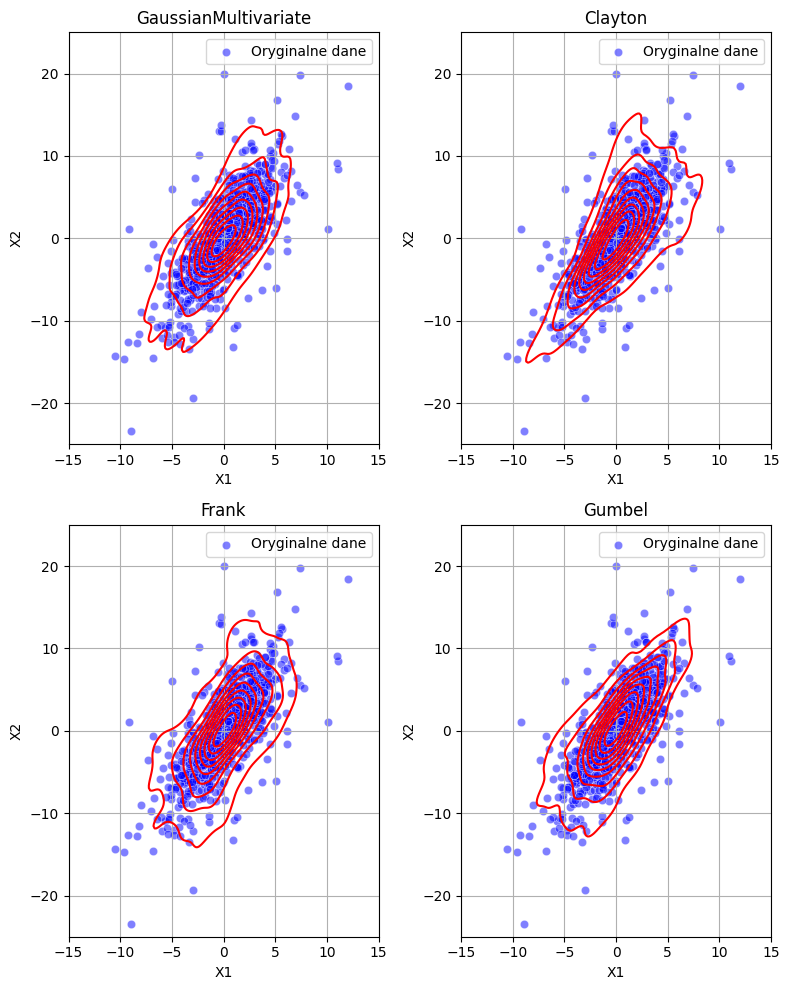

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(8, 10))
axes = ax.flatten()

for i, (samples_real_df, title) in enumerate(samples_real):
    sns.scatterplot(
        x=data["diff_aapl"], y=data["diff_msft"],
        ax=axes[i], color="blue", alpha=0.5, label="Oryginalne dane"
    )
    sns.kdeplot(x=samples_real_df["X1"], y=samples_real_df["X2"], ax=axes[i], color="red")
    axes[i].set_title(title)
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")
    axes[i].legend()
    axes[i].set_xlim(-15, 15)
    axes[i].set_ylim(-25, 25)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Wnioski...

## Test Mardia
Możemy wykonać test na wielowymiarową normalność:

In [46]:
mardia_test = multivariate_normality(data[["diff_aapl", "diff_msft"]], alpha=0.05)

print("Test Mardia:")
print(mardia_test)

Test Mardia:
HZResults(hz=np.float64(10.909247830035115), pval=np.float64(2.901245832950819e-24), normal=False)


Niska wartość p oznacza, że możemy odrzucić hipotezę zerową, czyli założenie, że dane są wielowymiarowo normalne.

## Krok 4a
Wygenerować N wektorów ($x_1$,$x_2$), gdzie $x_1$ pochodzą z pierwszego rozkładu brzegowego, a $x_2$ z drugiego, więc rozkłady są niezależne.\
Dopasować $\beta \in [0,1]$ tak, żeby VaR portfela $\beta x_1 + (1-\beta) x_2$ jest najmniejszy.\
Zinterpretować wartość $\beta$.

In [47]:
N = 10000
beta_range = np.linspace(0, 1, 101)

Generujemy próbki z rozkładów brzegowych (niezależnie):

In [48]:
samples_x1 = marginal_aapl.sample(N)
samples_x2 = marginal_msft.sample(N)
samples_x1, samples_x2

(array([-5.59166446,  5.42224617,  0.74919827, ..., -2.50407573,
         6.76643599,  0.29445451]),
 array([-4.40284368,  4.2361014 ,  5.32429925, ...,  1.65944597,
         0.60872993, -2.06087353]))

Obliczamy VaR dla portfela dla różnych wartości $\beta$:

In [49]:
var_results = []

for beta in beta_range:
    portfolio_values = beta * samples_x1 + (1 - beta) * samples_x2
    VaR_95 = np.quantile(portfolio_values, 0.05)
    var_results.append((beta, VaR_95))

var_results = pd.DataFrame(var_results, columns=["Beta", "VaR"])
print(var_results)

     Beta       VaR
0    0.00 -7.497271
1    0.01 -7.428446
2    0.02 -7.354573
3    0.03 -7.274427
4    0.04 -7.204459
..    ...       ...
96   0.96 -3.846533
97   0.97 -3.872096
98   0.98 -3.894207
99   0.99 -3.932185
100  1.00 -4.001065

[101 rows x 2 columns]


Aby zminimalizować straty, należy maksymalizować wartość VaR, ponieważ wartości strat są ujemne. Zatem poszukujemy takiego $\beta$, dla którego VaR jest najmniej negatywny (największy z ujemnych):

In [50]:
optimal_row = var_results.loc[var_results["VaR"].idxmax()]
optimal_beta = optimal_row["Beta"]
optimal_var = optimal_row["VaR"]
print(f"Optymalne beta: {optimal_beta}")
print(f"Minimalne VaR: {optimal_var}")

Optymalne beta: 0.8200000000000001
Minimalne VaR: -3.5655819226569814


Zinterpretować wartość $\beta$...

## Krok 4b
Wygenerować N wektorów $(x_1,x_2)$ z kopuły.\
Dopasować $\beta \in [0,1]$ tak, żeby VaR portfela $\beta x_1 + (1-\beta) x_2$ jest najmniejszy.\
Zinterpretować wartość $\beta$.

### Sklarpy - generuje samples już przetransformowane do wartości rzeczywistych

In [51]:
frank_samples = frank_fit.rvs(N)

var_results_frank = []

for beta in beta_range:
    portfolio_values_frank = beta * frank_samples[:, 0] + (1 - beta) * frank_samples[:, 1]
    VaR_95_frank = np.quantile(portfolio_values_frank, 0.05)
    var_results_frank.append((beta, VaR_95_frank))

var_results_frank = pd.DataFrame(var_results_frank, columns=["Beta", "VaR"])
print(var_results_frank)

optimal_row_frank = var_results_frank.loc[var_results_frank["VaR"].idxmax()]
optimal_beta_frank = optimal_row_frank["Beta"]
optimal_var_frank = optimal_row_frank["VaR"]
print(f"Optymalne beta dla próbek z kopuły Franka: {optimal_beta_frank}")
print(f"Minimalne VaR dla próbek z kopuły Franka: {optimal_var_frank}")

     Beta       VaR
0    0.00 -7.311862
1    0.01 -7.282230
2    0.02 -7.243578
3    0.03 -7.200633
4    0.04 -7.176253
..    ...       ...
96   0.96 -4.292412
97   0.97 -4.258119
98   0.98 -4.224863
99   0.99 -4.191313
100  1.00 -4.153877

[101 rows x 2 columns]
Optymalne beta dla próbek z kopuły Franka: 1.0
Minimalne VaR dla próbek z kopuły Franka: -4.153876729565252


### Copulas
Generujemy próbki z dopasowanej kopuły Franka:

In [52]:
copula = Frank()
copula.fit(data_u)
samples_copula = copula.sample(n_samples=N)

Ponieważ próbki wygenerowane z kopuły należą do przedziału (0,1) musimy je przetransformować z powrotem do wartości rzeczywistych:

In [53]:
samples_x1_copula = marginal_aapl.ppf(samples_copula[:, 0])
samples_x2_copula = marginal_msft.ppf(samples_copula[:, 1])
samples_x1_copula, samples_x2_copula

(array([ 0.05930561,  1.78802689, -1.02607414, ..., -0.16000903,
         1.48245438, -1.4727723 ]),
 array([-1.46340468,  0.86738949, -4.94673918, ...,  0.58467902,
         5.89020539, -2.92479919]))

Obliczamy VaR dla portfela dla różnych wartości beta:

In [54]:
var_results_copula = []

for beta in beta_range:
    portfolio_values_copula = beta * samples_x1_copula + (1 - beta) * samples_x2_copula
    VaR_95_copula = np.quantile(portfolio_values_copula, 0.05)
    var_results_copula.append((beta, VaR_95_copula))

var_results_copula = pd.DataFrame(var_results_copula, columns=["Beta", "VaR"])
print(var_results_copula)

     Beta       VaR
0    0.00 -7.078257
1    0.01 -7.027916
2    0.02 -6.995515
3    0.03 -6.951124
4    0.04 -6.909963
..    ...       ...
96   0.96 -4.104442
97   0.97 -4.084808
98   0.98 -4.079510
99   0.99 -4.059614
100  1.00 -4.047364

[101 rows x 2 columns]


Aby zminimalizować straty i wyznaczyć optymalne $\beta$, będziemy maksymalizować wartość VaR:

In [55]:
optimal_row_copula = var_results_copula.loc[var_results_copula["VaR"].idxmax()]
optimal_beta_copula = optimal_row_copula["Beta"]
optimal_var_copula = optimal_row_copula["VaR"]
print(f"Optymalne beta dla próbek z kopuły: {optimal_beta_copula}")
print(f"Minimalne VaR dla próbek z kopuły: {optimal_var_copula}")

Optymalne beta dla próbek z kopuły: 1.0
Minimalne VaR dla próbek z kopuły: -4.047364102604728


In [56]:
print(f"Optymalne beta: {optimal_beta}")
print(f"Minimalne VaR: {optimal_var}")
print()
print(f"Optymalne beta dla próbek z kopuły Franka: {optimal_beta_frank}")
print(f"Minimalne VaR dla próbek z kopuły Franka: {optimal_var_frank}")

Optymalne beta: 0.8200000000000001
Minimalne VaR: -3.5655819226569814

Optymalne beta dla próbek z kopuły Franka: 1.0
Minimalne VaR dla próbek z kopuły Franka: -4.153876729565252


Zinterpretować wartość $\beta$, porównać 4a i 4b, podać wnioski...

## Krok 5
Porównać wyniki z 4a i 4b. Sprawdzić, jak zmieniają się wyniki dla dwóch różnych poziomów VaR i wartości N. Skomentować.

Porównamy jak zmieniają się wyniki dla VaR 95% i 99% oraz dla próbek w ilości 1000, 10000 i 50000:

In [57]:
VaR_levels = [0.05, 0.01]
N_values = [1000, 10000, 50000]

comparison_results = []

for var_level in VaR_levels:
    for N in N_values:
        samples_x1 = marginal_aapl.sample(N)
        samples_x2 = marginal_msft.sample(N)
        portfolio_values = beta_range[:, None] * samples_x1 + (1 - beta_range[:, None]) * samples_x2.T
        
        samples_copula = copula.sample(n_samples=N)
        samples_x1_copula = marginal_aapl.ppf(samples_copula[:, 0])
        samples_x2_copula = marginal_msft.ppf(samples_copula[:, 1])
        portfolio_values_copula = beta_range[:, None] * samples_x1_copula + (1 - beta_range[:, None]) * samples_x2_copula.T
        
        var_independent = np.quantile(portfolio_values, var_level, axis=1)
        var_copula = np.quantile(portfolio_values_copula, var_level, axis=1)
        
        comparison_results.append({
            "Poziom VaR": (1-var_level)*100,
            "N": N,
            "Optymalne beta": beta_range[np.argmax(var_independent)],
            "Minimalne VaR": var_independent[np.argmax(var_independent)],
            "Optymalne beta z kopuły": beta_range[np.argmax(var_copula)],
            "Minimalne VaR z kopuły": var_copula[np.argmax(var_copula)]
        })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)

   Poziom VaR      N  Optymalne beta  Minimalne VaR  Optymalne beta z kopuły  \
0        95.0   1000            0.82      -3.296234                     0.97   
1        95.0  10000            0.78      -3.507471                     1.00   
2        95.0  50000            0.79      -3.558365                     1.00   
3        99.0   1000            0.71      -5.314226                     0.90   
4        99.0  10000            0.75      -5.731620                     0.91   
5        99.0  50000            0.76      -5.735537                     0.96   

   Minimalne VaR z kopuły  
0               -4.042106  
1               -4.091215  
2               -4.043715  
3               -6.269466  
4               -6.666612  
5               -6.624627  


Porównanie i wnioski...